# Example 3.
# Learnable Dynamics for Karplus-Strong with a Differentiable Biquad Filter

## Creating Bursts from Target

In [1]:
import matplotlib.pyplot as plt

def plot_waveforms(
    signals,
    titles=None,
    labels=None,
    sample_rate=16000,
    figsize=(10, 2.5),
    sharex=True
):
    num_plots = len(signals)
    fig, axs = plt.subplots(num_plots, 1, figsize=(figsize[0], figsize[1] * num_plots), sharex=sharex)

    # Make axs iterable even if there's only one subplot
    if num_plots == 1:
        axs = [axs]

    for i, ax in enumerate(axs):
        subplot_signals = signals[i] if isinstance(signals[i], (list, tuple)) else [signals[i]]
        t = torch.arange(subplot_signals[0].numel()) / sample_rate

        for j, y in enumerate(subplot_signals):
            label = None
            if labels is not None:
                if isinstance(labels[0], (list, tuple)):
                    label = labels[i][j] if i < len(labels) and j < len(labels[i]) else None
                else:
                    label = labels[j] if j < len(labels) else None
            ax.plot(t, y.detach().cpu(), label=label)

        if titles and i < len(titles):
            ax.set_title(titles[i])
        ax.set_ylabel("Amplitude")
        if label:
            ax.legend()

    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()

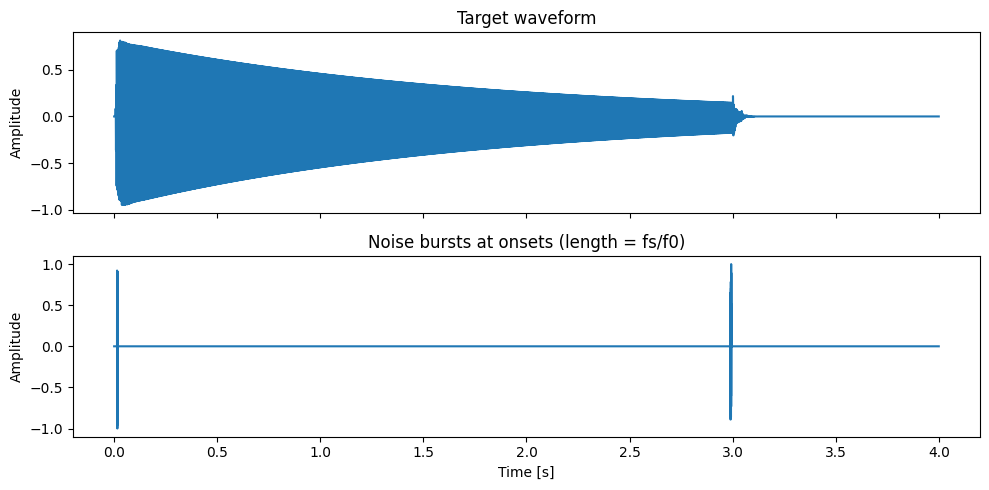

In [2]:
import librosa
from ddsp.utils import detect_f0, detect_onsets, bursts_at_onsets
import torch

sr = 16000
frame_hop = 4096

target, _ = librosa.load("target_audio/test.wav", sr=sr, mono=True)
onset_samples = detect_onsets(target, sr)
f0 = detect_f0(target, sr, hop_length=frame_hop, frame_length=frame_hop)
bursts = bursts_at_onsets(target, sr, onset_samples, f0, burst_range=1.0, seed=42)

plot_waveforms(
    [torch.tensor(target), torch.tensor(bursts)],
    titles=["Target waveform", "Noise bursts at onsets (length = fs/f0)"],
    sample_rate=sr
)

## Optimising with a Differentiable Biquad (piecewise-constant between onsets)

Optimizing DynamicsShaper + DiffKS: 100%|████████| 300/300 [00:22<00:00, 13.12it/s, loss=171.736832]


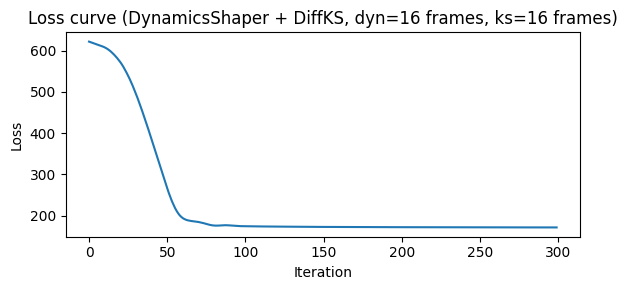

In [3]:
import warnings
warnings.filterwarnings("ignore", message="Custom extension not loaded")
warnings.filterwarnings("ignore", message="Cannot find custom extension")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Audio, display

import sys, os
acid_ddsp_root = os.path.join(os.getcwd(), "..", "TB303", "acid_ddsp")
acid_ddsp_root = os.path.abspath(acid_ddsp_root)
if acid_ddsp_root not in sys.path:
    sys.path.append(acid_ddsp_root)

from ddsp.utils import LogMSSLoss
from ddsp.dynamics_shaper import DynamicsShaper, segment_ids_from_onsets
from ddsp.diff_ks import DiffKSIIRLoopLearnableCoefficients

device = torch.device("cpu")
dtype = torch.float32

# Make tensors
x_tgt = torch.tensor(target, dtype=dtype, device=device).unsqueeze(0)     # [1, N]
noise_in = torch.tensor(bursts, dtype=dtype, device=device).unsqueeze(0)  # [1, N]
N = x_tgt.shape[-1]

# Interpolate f0 to sample-rate and compute period L=fs/f0
t_audio = np.arange(N) / sr
t_f0 = np.arange(len(f0)) * frame_hop / sr
f0 = np.interp(t_audio, t_f0, np.nan_to_num(f0, nan=0.0))
f0_n = torch.tensor(sr / f0, dtype=dtype, device=device).unsqueeze(0)     # [1, N]

# Build segment labels from onsets
onsets_t = torch.tensor(onset_samples, dtype=torch.long, device=device)
segment_ids = segment_ids_from_onsets(onsets_t, T=N, device=device).unsqueeze(0)  # [1, N]

# Create logits, instantiate  stuff...
num_frames = 16

shaper_logits_frames = nn.Parameter(torch.zeros(1, num_frames, 3, device=device))  # [1, num_frames, 3] -> DynamicsShaper: 3 channels (gain, w_mod, q_mod)
diffks_logits_frames = nn.Parameter(torch.zeros(1, num_frames, 2, device=device))  # [1, num_frames, 2] -> DiffKS: 2 channels (g, p)

shaper = DynamicsShaper(gain_min=0.1, gain_max=2.0, sr=sr)
diffks = DiffKSIIRLoopLearnableCoefficients().to(dtype)

loss_fn = LogMSSLoss()
optimizer = optim.AdamW([shaper_logits_frames, diffks_logits_frames], lr=1e-1)

num_iters = 300
loss_history = []

pbar = tqdm(range(num_iters), desc="Optimizing DynamicsShaper + DiffKS", ncols=100)
for i in pbar:
    optimizer.zero_grad()

    # upsample frames -> samples
    shaper_logits_samples = F.interpolate(shaper_logits_frames.permute(0, 2, 1), size=N, mode="linear", align_corners=True).permute(0, 2, 1)
    diffks_logits_samples = F.interpolate(diffks_logits_frames.permute(0, 2, 1), size=N, mode="linear", align_corners=True).permute(0, 2, 1)

    if i == num_iters - 1:
        x_shaped, _stats_shaper = shaper(noise_in, segment_ids, shaper_logits_samples, return_stats=True)
        y_pred, _stats_diffks = diffks(f0=f0_n, input=x_shaped, l_b=diffks_logits_samples, return_stats=True)
    else:
        x_shaped = shaper(noise_in, segment_ids, shaper_logits_samples)  # [1, N]
        y_pred = diffks(f0=f0_n, input=x_shaped, l_b=diffks_logits_samples)  # [1, N]

    loss = loss_fn(y_pred.unsqueeze(1), x_tgt.unsqueeze(1))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    pbar.set_postfix({"loss": f"{loss.item():.6f}"})

y_out = y_pred.detach().cpu()[0]
y_tgt = x_tgt.detach().cpu()[0]
x_shaped_out = x_shaped.detach().cpu()[0]

plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title(f"Loss curve (DynamicsShaper + DiffKS, dyn={num_frames} frames, ks={num_frames} frames)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

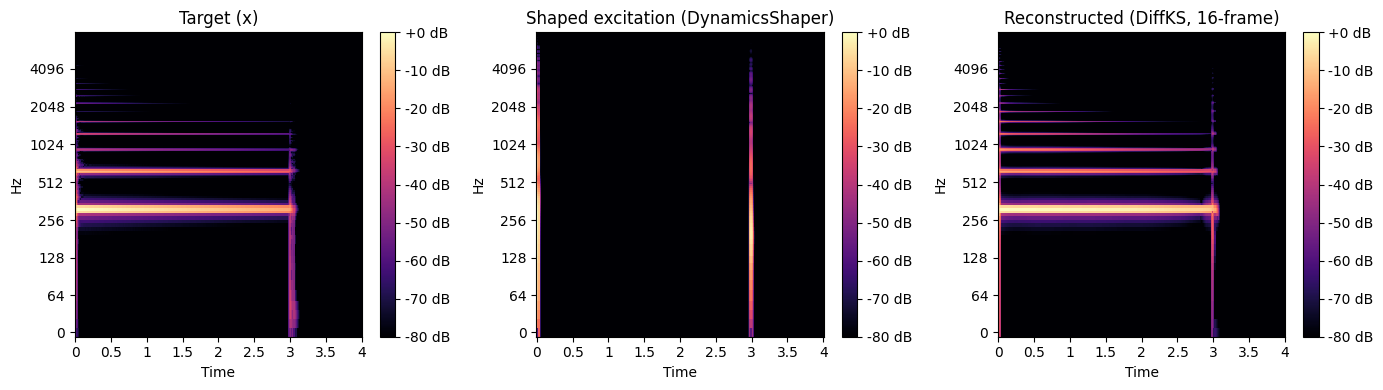


▶ Target



▶ Shaped excitation (DynamicsShaper)



▶ Reconstructed (DynamicsShaper → DiffKS)


In [4]:
import librosa
import librosa.display

def plot_spectrograms(signals, sr, titles, n_fft=1024, hop_length=256, vmin=-80, vmax=0):
    """
    Plot log-magnitude spectrograms for multiple 1D signals.
    """
    # Ensure all signals are numpy arrays on CPU
    signals = [sig.detach().cpu().numpy() if torch.is_tensor(sig) else sig for sig in signals]

    fig, axes = plt.subplots(1, len(signals), figsize=(14, 4))
    if len(signals) == 1:
        axes = [axes]

    for i, (sig, ax, title) in enumerate(zip(signals, axes, titles)):
        S = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        img = librosa.display.specshow(
            S_db,
            sr=sr,
            hop_length=hop_length,
            x_axis="time",
            y_axis="log",
            cmap="magma",
            vmin=vmin,
            vmax=vmax,
            ax=ax,
        )
        ax.set_title(title)
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

# Plot final results as spectrograms
plot_spectrograms(
    [y_tgt, x_shaped_out, y_out],
    sr=sr,
    titles=[
        "Target (x)",
        "Shaped excitation (DynamicsShaper)",
        f"Reconstructed (DiffKS, {num_frames}-frame)",
    ],
)

# Listen to the results
print("\n▶ Target")
display(Audio(y_tgt, rate=sr))
print("\n▶ Shaped excitation (DynamicsShaper)")
display(Audio(x_shaped_out, rate=sr))
print("\n▶ Reconstructed (DynamicsShaper → DiffKS)")
display(Audio(y_out, rate=sr))

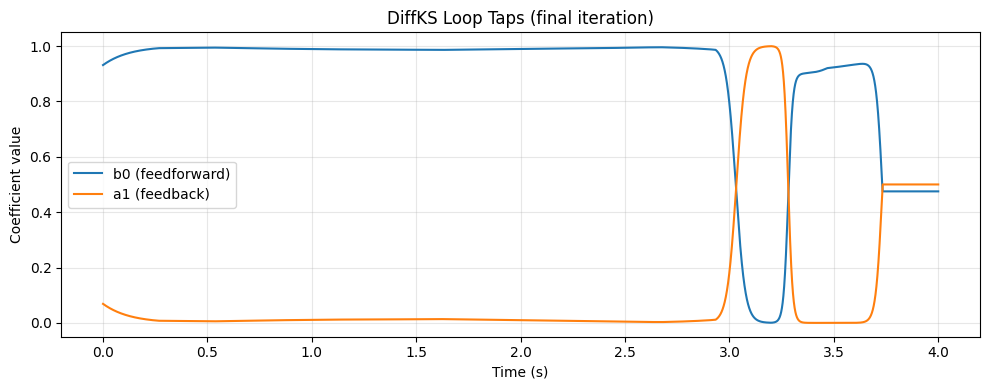

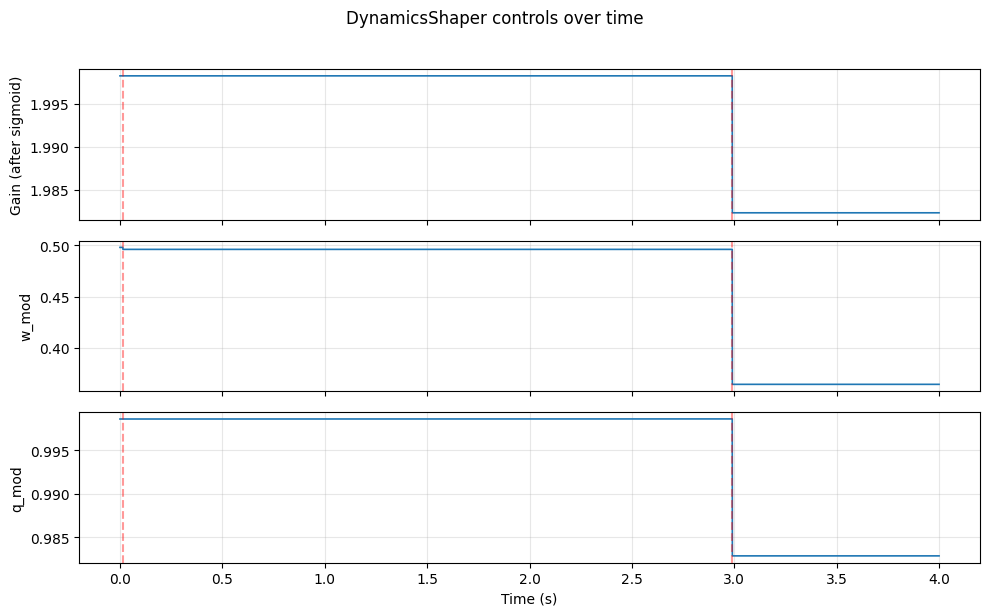

Unique segment IDs: 3


In [5]:
# -----------------------------
# Plot DiffKS loop filter taps
# -----------------------------
def plot_diffks_stats(stats, sr):
    """
    Visualize learned DiffKS loop taps from the final iteration.
    """
    taps = stats["taps"].squeeze(0).detach().cpu().numpy()  # [N, 2] = [b0, a1]
    time = np.linspace(0, taps.shape[0] / sr, taps.shape[0])

    plt.figure(figsize=(10, 4))
    plt.plot(time, taps[:, 0], label="b0 (feedforward)")
    plt.plot(time, taps[:, 1], label="a1 (feedback)")
    plt.title("DiffKS Loop Taps (final iteration)")
    plt.xlabel("Time (s)")
    plt.ylabel("Coefficient value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Plot DynamicsShaper statistics
# -----------------------------
def plot_dynamics_shaper_stats(stats, sr, onsets=None):
    """
    Visualize the per-sample controls returned by DynamicsShaper.
    """
    gain = stats["gain"].squeeze(0).detach().cpu().numpy()
    w_mod = stats["w_mod"].squeeze(0).detach().cpu().numpy()
    q_mod = stats["q_mod"].squeeze(0).detach().cpu().numpy()
    seg_ids = stats["segment_ids"].squeeze(0).detach().cpu().numpy()
    time = np.linspace(0, len(gain) / sr, len(gain))

    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    labels = ["Gain (after sigmoid)", "w_mod", "q_mod"]

    for ax, data, label in zip(axes, [gain, w_mod, q_mod], labels):
        ax.plot(time, data, linewidth=1.2)
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        if onsets is not None:
            for onset in onsets:
                ax.axvline(onset / sr, color="red", linestyle="--", alpha=0.4)
    axes[-1].set_xlabel("Time (s)")
    fig.suptitle("DynamicsShaper controls over time", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"Unique segment IDs: {len(np.unique(seg_ids))}")


# --- Plot the stats from the last forward pass ---
plot_diffks_stats(_stats_diffks, sr)
plot_dynamics_shaper_stats(_stats_shaper, sr, onsets=onsets_t.cpu().numpy())